In [1]:
import json
import simpleGraph as sG
import utils as util
import simpleGraphUtils as sGUtil
import utils as u
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu, wilcoxon



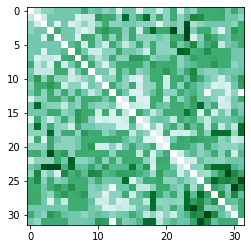

In [2]:
tinyG = sG.simpleGraph('../src/utils/amazon_32x1_graph.json')
sGUtil.plotGraphAsMatrix(tinyG, filename = 'amazon_32x1_heatmap')

import seaborn as sns
import pandas as pd
sns.set()

In [3]:
#Load the data from json file
with open('AllConfigurations.json') as jsonFile:
    permutationProfil = []
    data = json.load(jsonFile)
    for key, value in data.items():
        permutationProfil.append((json.loads(key), value))
    
n_nodes = len(permutationProfil[0][0])
ppn = len(permutationProfil[0][0][0])*len(permutationProfil[0][0][0][0])
print('Number of nodes={} and number of processes per node={}'.format(n_nodes, ppn))

Number of nodes=16 and number of processes per node=32


In [4]:
#Convert the list of node, containing a list of sockets, containing a list of IDs to permtutation vector

def convertToArray(nodeConfig):
    """
    Gets a list of lists: Each node is a list contatining a list of sockets containing a list of cores.
    For the evaluation we use a simple list, thus we extract the information from that
    """
    p = []
    for node in nodeConfig:
        for socket in node:
            for core in socket:
                p.append(core)
    return p

def convertAllToArray(config):
    """
    Transforms the list containing all nodeConfigs and time to a list containing the configurations as
    Arrays with the corresponding time. So we can use the functions already implemented in utils.py
    """
    c = []
    for nodeConfig, time in config:
        c.append((convertToArray(nodeConfig), time))
    return c

permutationAndTimes = convertAllToArray(permutationProfil)

In [5]:
#Count the amount of sum of inter-node communication and the bottleneck for every permutation seen

def countInterNodeCommunication(G, p, g_nodes, g_ppn):
    """
    Simple method that collects the number of internode communication, both sum and bottleneck
    for a permutation p, given n_nodes number of nodes with ppn processes per node. The graph is
    assumed to be directed
    :param G: simpleGraph needed for neighbor extraction
    :param p: permutation parameter as list
    :return: a tuple with bottleneck b and total s number of inter-node connections b,s
    """
    #n_nodes, ppn = getNumberOfNodesUsed(p)
    #bottleneck, sum
    sum = 0
    perNode = [0 for _ in range(g_nodes)]
    for index, rank in enumerate(p):
        # Takes care of the possibility that we have more hardware ressources than processes
        if rank < 0:
            continue
        rankNodeID = index // g_ppn
        for neighbor in G.getUnweightedNeighbors(rank):
            neighborIndex = p.index(neighbor)
            neighborNodeID = neighborIndex // g_ppn
            if neighborNodeID != rankNodeID:
                sum += 1
                perNode[rankNodeID] += 1
        index += 1
    return (max(perNode), sum)


def getNodeInformation(p):
    nodesUsed = 0
    minCores = np.inf
    maxCores = 0
    meanCores = 0
    for i in range(0, len(p), ppn):
        nodeConfig = p[i:i+ppn]
        sumCores = 0
        anyAssigned = False
        for val in nodeConfig:
            if val > -1:
                sumCores += 1
                anyAssigned = True
        if anyAssigned:
            nodesUsed += 1
        if sumCores > maxCores:
            maxCores = sumCores
        if sumCores > 0 and sumCores < minCores:
            minCores = sumCores
        meanCores += sumCores
    meanCores /= nodesUsed
    return (nodesUsed, maxCores, minCores, meanCores)

def extractInterNodeCommInfo(G, config):
    """
    Getting a list of tuples, with first one permutation and the second the time and a Graph,
    we want to extract for each permutation the total number of inter-node communication and 
    the bottleneck value and append it to the tuple
    """
    c = []
    for p, t in config:
        nodesUsed, maxCores, minCores, meanCores = getNodeInformation(p)
        if not np.isfinite(t):
            t = np.nan
        try:
            bottleneck, total = countInterNodeCommunication(G, p, n_nodes, ppn)
        except RuntimeError as e:
            print("FAILURE\n p={}".format(p))
            break
        c.append(((p, t, bottleneck, total, nodesUsed, maxCores, minCores, meanCores)))
    return c
        
allValues = extractInterNodeCommInfo(tinyG, permutationAndTimes)
print('Bottleneck={}, Sum={}, Time={}'.format(allValues[0][2], allValues[0][3], allValues[0][1]))

Bottleneck=0, Sum=0, Time=9.644621


In [6]:
df = pd.DataFrame(allValues, columns=['Permutation', 'Time', 'Bottleneck', 'Sum', '#Nodes', 'max#cores', 'min#cores', 'mean#cores'])
df
df.corr(method='spearman')

,Time,Bottleneck,Sum,#Nodes,max#cores,min#cores,mean#cores
Time,1.000000,0.166420,-0.199039,-0.211349,0.168715,0.054035,0.211349
Bottleneck,0.166420,1.000000,-0.763453,-0.345978,0.997528,-0.047206,0.345978
Sum,-0.199039,-0.763453,1.000000,0.703624,-0.765756,0.009080,-0.703624
#Nodes,-0.211349,-0.345978,0.703624,1.000000,-0.348374,-0.024968,-1.000000
max#cores,0.168715,0.997528,-0.765756,-0.348374,1.000000,-0.029004,0.348374
min#cores,0.054035,-0.047206,0.009080,-0.024968,-0.029004,1.000000,0.024968
mean#cores,0.211349,0.345978,-0.703624,-1.000000,0.348374,0.024968,1.000000


In [7]:
print(df.sort_values('Time').head(10)['Time'])
bestPermutations = df.sort_values('Time').head(1)['Permutation']
jsonDict = {}
for permutation in bestPermutations:
    jsonDict['Perm'] = permutation
print(jsonDict)
with open('SeedFile.json', 'w') as f:
    json.dump(jsonDict, f)

1577    5.834033
1961    5.835883
2164    5.840337
2331    5.840700
2133    5.841504
1489    5.842469
2141    5.845909
1667    5.846559
1307    5.847373
2753    5.848560
Name: Time, dtype: float64
{'Perm': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 16, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 20, -1, -1, -1, -1, -1, -1, -

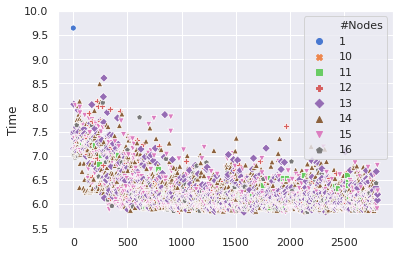

In [8]:
df.head()
grid = sns.scatterplot(x=df.index, y='Time', data=df, hue='#Nodes', palette='muted', style='#Nodes')
grid.set(ylim=[5.5, 10])
grid.get_figure().savefig('Distribution_over_time', format='pdf')

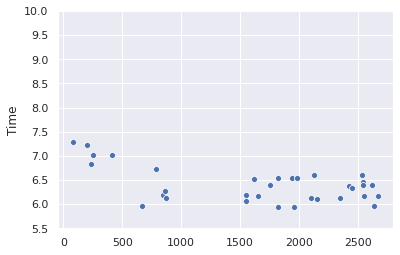

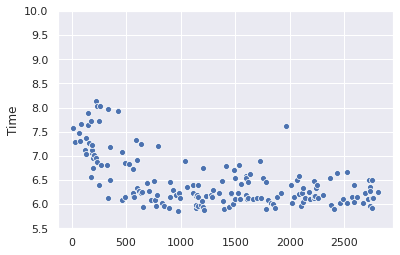

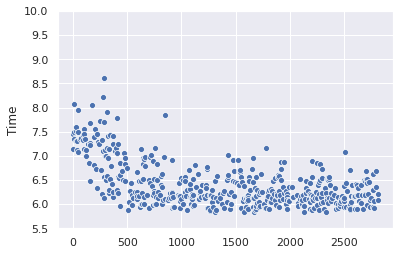

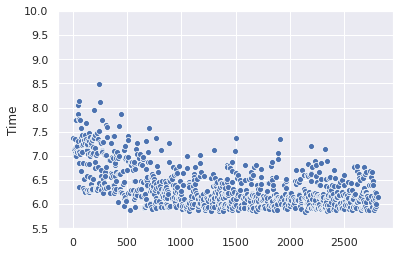

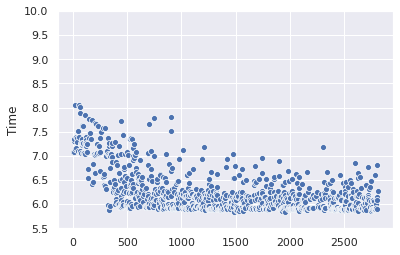

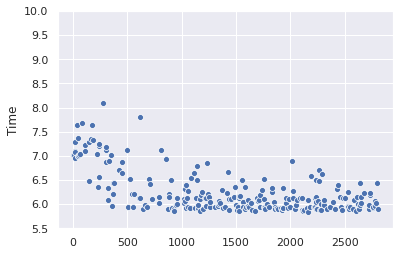

544.5 0.4974 2771.0 0.4156 7269.0 0.2430 13697.0 0.1156 10106.0 0.0003 2558.0 0.0005 
14792.0 0.4998 38973.0 0.1858 73600.0 0.0232 55544.0 0.0000 13983.0 0.0000 
112812.5 0.5000 214176.0 0.0751 164368.0 0.0000 41445.5 0.0000 
447458.0 0.5000 343439.0 0.0000 87136.0 0.0000 
444624.5 0.5000 112332.0 0.4305 
28800.0 0.4999 


In [9]:
n_nodesTimesList = []
for i in range(11, 17):
    n_nodesTimesList.append(df[df['#Nodes']==i]['Time'])
    g = sns.scatterplot(x=df[df['#Nodes'] == i].index, y='Time', data=df[df['#Nodes'] == i])
    g.set(ylim=[5.5, 10])
    plt.show()

whitneyUMatrix = []
for i in range(len(n_nodesTimesList)):
    testRow = []
    for j in range(i, len(n_nodesTimesList)):
        testRow.append(mannwhitneyu(n_nodesTimesList[i], n_nodesTimesList[j]))
    whitneyUMatrix.append(testRow)
whitneyUMatrix
for row in whitneyUMatrix:
    for statistic, pvalue in row:
        print('{} {:5.4f}'.format(statistic, pvalue), end= ' ')
    print('')
        

In [ ]:
g = sns.FacetGrid(df, col='Time', row='#Nodes')
g = g.map(plt.line, df.index)
#sns.PairGrid(df, vars=['Time', '#Node', 'Sum', 'Max'], dropna=True)
#sns.pointplot(x=df.index, y='Time', hue='#Nodes', kind='line', estimator=np.median, data=df)

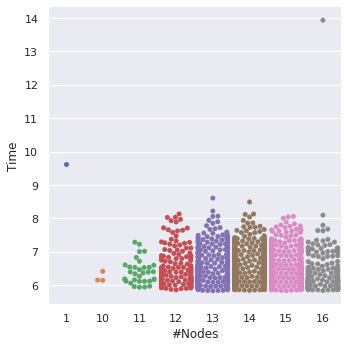

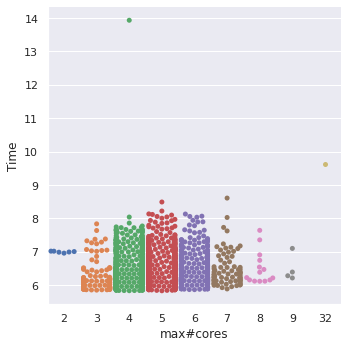

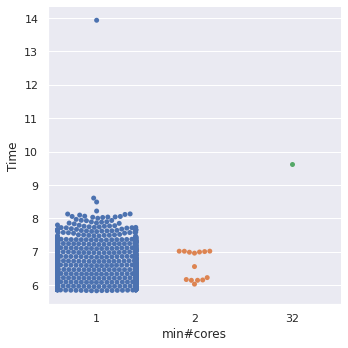

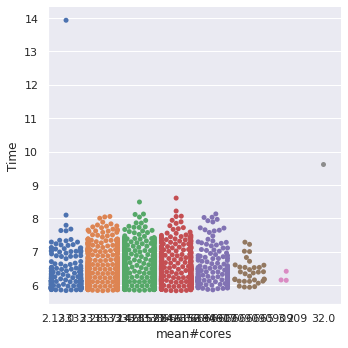

In [13]:
fig = sns.catplot(x='#Nodes', y='Time', data=df, estimator=np.mean, kind='swarm')
fig.savefig('cat_n_nodes_time', format='pdf')

fig = sns.catplot(x='max#cores', y='Time', data=df, estimator=np.mean, kind='swarm')
fig.savefig('cat_max_n_cores_time', format='pdf')

fig = sns.catplot(x='min#cores', y='Time', data=df, estimator=np.mean, kind='swarm')
fig.savefig('cat_min_c_cores_time', format='pdf')

fig = sns.catplot(x='mean#cores', y='Time', data=df, estimator=np.mean, kind='swarm')
fig.savefig('cat_mean_n_cores_time', format='pdf')


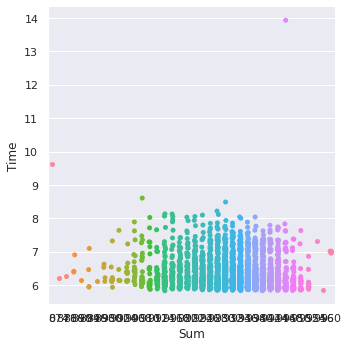

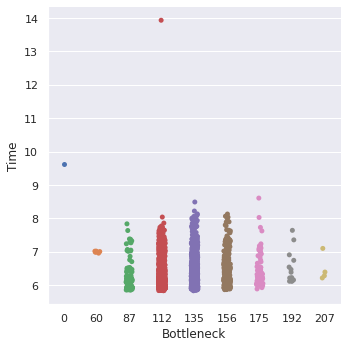

In [8]:
#Plot the scatter plot of both sum/bottleneck to solver time
sns.catplot(x='Sum', y='Time', data=df)
sns.catplot(x='Bottleneck', y='Time', data=df)

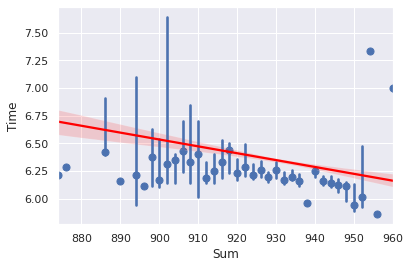

In [14]:
#drop infinite numbers
df.replace([np.inf, float('inf')], np.nan)
df.dropna(how='all')

bestPermutation = df[df.Time == df.Time.min()].Permutation.tolist()

excludingZero = df.loc[df['Sum'] > 0]

#Plot linear regression of the time to solve system to sum of inter-node communication
fig = sns.regplot(x='Sum', y='Time', data=excludingZero, x_estimator=np.median, fit_reg=True, ci=95, line_kws={'color':'red'});
fig.get_figure().savefig('linear_regression', format='pdf')


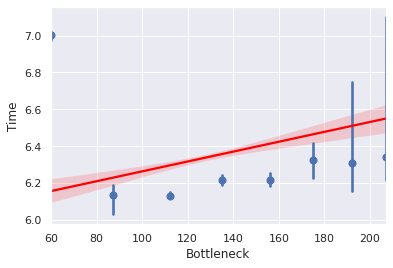

In [10]:
#Plot linear regression of the time to solve system to bottleneck
sns.regplot(x='Bottleneck', y='Time', data=excludingZero, x_estimator=np.median, fit_reg=True, ci=95, line_kws={'color':'red'});

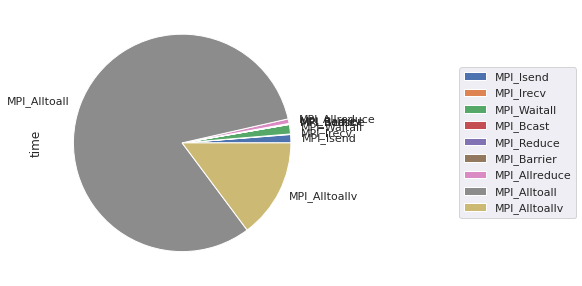

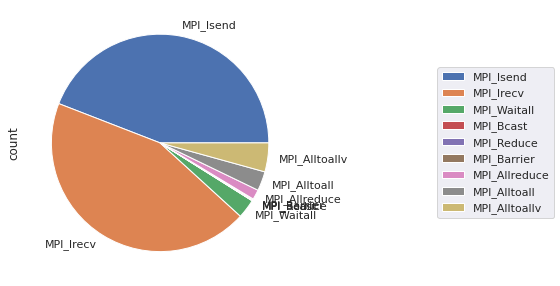

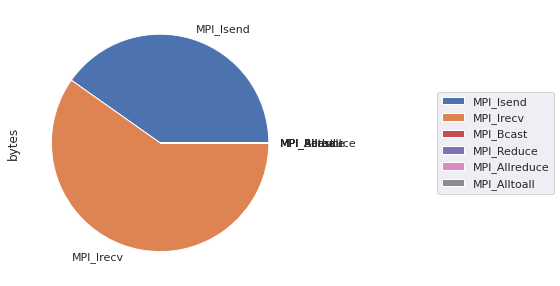

In [10]:
MPI_data = pd.read_csv('../src/utils/amazon_32x1.pd')
MPI_data = MPI_data.loc[:, ~MPI_data.columns.str.contains('^Unnamed')]
MPI_data.set_index('name')

#Reduce the amount of categories
rankzero = MPI_data.loc[MPI_data['rank']==0]
rankzero = rankzero.loc[rankzero['name'] != 'MPI_Comm_rank']
rankzero = rankzero.loc[rankzero['name'] != 'MPI_Comm_size']
rankzero = rankzero.loc[rankzero['name'] != 'MPI_Init']
rankzero = rankzero.loc[rankzero['name'] != 'MPI_Finalize']
rankzero.set_index('name')

#Plot cumulative time
fig = rankzero.plot.pie(y='time', normalize=True, labels=rankzero['name'], figsize=(5,5), subplots=True, legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.show()
fig[0].get_figure().savefig('time_piechart.pdf', format='pdf', bbox_inches='tight')
plt.close()
#Plot cumulative calls
fig = rankzero.plot.pie(y='count', normalize=True, labels=rankzero['name'], figsize=(5,5), subplots=True, legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.show()
fig[0].get_figure().savefig('count_piechart.pdf', format='pdf', bbox_inches='tight')
plt.close()
#plot cumulativ bytes
fig = rankzero.plot.pie(y='bytes', normalize=True, labels=rankzero['name'], figsize=(5,5), subplots=True, legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.show()
fig[0].get_figure().savefig('bytes_piechart.pdf', format='pdf', bbox_inches='tight')